In [324]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncnorm

import torch
from torchvision import datasets, transforms


In [287]:
def type_it(check):
    print(type(check))
    if isinstance(check, torch.Tensor):
        print(check.size())
    return

def plot_detail_color(image_tensor):
    image_np = image_tensor.permute(1, 2, 0).numpy()
    plt.figure(figsize=(1, 1))
    plt.imshow(image_np, cmap='gray')
    plt.show()

def plot_detail(image_tensor):
    plt.figure(figsize=(1, 1))
    plt.imshow(image_tensor, cmap='gray')
    plt.show()

In [288]:
def rotate_dataset(
        datasets: torch.Tensor,
        degree: int = 90
    ) -> torch.Tensor:
    '''
    Rotates all images in the dataset by a specified degree.

    Args:
        datasets (torch.Tensor): Input dataset, a tensor of shape (N, (), H, W) where N is the number of images.
        rotation (int) : Degrees to rotate each image.

    Returns:
        torch.Tensor: The rotated dataset, a tensor of the same shape (N, (), H, W) as the input.
    '''
    rotated_images = []
    
    for img_tensor in datasets:
        # Convert the tensor to a PIL image
        img = transforms.ToPILImage()(img_tensor)
        
        # Rotate the image
        rotated_img = img.rotate(degree)
        
        # Convert the PIL image back to a tensor
        rotated_img_tensor = transforms.ToTensor()(rotated_img).squeeze(0)
        
        rotated_images.append(rotated_img_tensor)
    
    # Stack all tensors into a single tensor
    rotated_dataset = torch.stack(rotated_images)
    
    return rotated_dataset

In [303]:
def color_dataset(
        dataset: torch.Tensor,
        color: str = 'red'
    ) -> torch.Tensor:
    '''
    Colors all images in the dataset by a specified color.

    Args:
        dataset (torch.Tensor): Input dataset, a tensor of shape (N, H, W) or (N, 3, H, W)
                                where N is the number of images.
        color (str) : 'red', 'green', 'blue'.


    Warning:
        MNIST, FMNIST, EMNIST are 1-channel. CIFAR10, CIFAR100 are 3-channel.

    Returns:
        torch.Tensor: The colored dataset, a tensor of the shape (N, 3, H, W) with 3 channels.
    '''

    if dataset.dim() == 3:
        # Handle 1-channel dataset
        colored_datasets = dataset.unsqueeze(1).repeat(1, 3, 1, 1) # Shape becomes (N, 3, H, W)
    elif dataset.dim() == 4 and dataset.size(1) == 3:
        colored_datasets = dataset
    else:
        raise ValueError("This function only supports 1-channel (N, H, W) or 3-channel (N, 3, H, W) datasets.")

    # Map the grayscale values to the specified color
    if color == 'red':
        colored_datasets[:, 0, :, :] = 1  # Set the red channel for the digits
    elif color == 'green':
        colored_datasets[:, 1, :, :] = 1  # Set the green channel for the digits
    elif color == 'blue':
        colored_datasets[:, 2, :, :] = 1  # Set the blue channel for the digits
    else:
        raise ValueError("Color must be 'red', 'green', or 'blue'")

    return colored_datasets

In [290]:
def load_full_datasets(
        dataset_name: str = "MNIST",
    ) -> list:
    '''
    Load datasets into four separate parts: train labels, train images, test labels, test images.

    Args:
        dataset_name (str): Name of the dataset to load. Options are 
        "MNIST", "FMNIST", "EMNIST", "CIFAR10", "CIFAR100".

    TODO: EMNIST IS NOT WELL.

    Returns:
        list: [4].
    '''
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    if dataset_name == "MNIST":
        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "FMNIST":
        train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "EMNIST": # byclass, bymerge, balanced, letters, digits
        train_dataset = datasets.EMNIST(root='./data', split='letters', train=True, download=True, 
                                            transform=torchvision.transforms.Compose([ 
                                            lambda img: torchvision.transforms.functional.rotate(img, -90), 
                                            lambda img: torchvision.transforms.functional.hflip(img), 
                                            torchvision.transforms.ToTensor()
                                            ])
                                        )               
        test_dataset = datasets.EMNIST(root='./data', split='letters', train=False, download=True,
                                                    transform=torchvision.transforms.Compose([ 
                                            lambda img: torchvision.transforms.functional.rotate(img, -90), 
                                            lambda img: torchvision.transforms.functional.hflip(img), 
                                            torchvision.transforms.ToTensor()
                                            ])
                                        )         
    elif dataset_name == "CIFAR10":
        train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    elif dataset_name == "CIFAR100":
        train_dataset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
        test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError(f"Dataset {dataset_name} is not supported.")

    # Extracting train and test images and labels
    train_images = torch.stack([data[0] for data in train_dataset]).squeeze(1)
    test_images = torch.stack([data[0] for data in test_dataset]).squeeze(1)
    
    if dataset_name in ["CIFAR10", "CIFAR100"]:
        train_labels = torch.tensor(train_dataset.targets).clone().detach()
        test_labels = torch.tensor(test_dataset.targets).clone().detach()
    else:
        train_labels = train_dataset.targets.clone().detach()
        test_labels = test_dataset.targets.clone().detach()

    return [train_images, train_labels, test_images, test_labels]

In [291]:
def split_basic(
    features: torch.Tensor,
    labels: torch.Tensor,
    client_number: int = 10,
    permute: bool = True
) -> list:
    """
    Splits a dataset into a specified number of clusters (clients).
    
    Args:
        features (torch.Tensor): The dataset features.
        labels (torch.Tensor): The dataset labels.
        client_number (int): The number of clients to split the data into.
        permute (bool): Whether to shuffle the dataset before splitting.

    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
    """

    # Ensure the features and labels have the same number of samples
    assert len(features) == len(labels), "The number of samples in features and labels must be the same."

    # Randomly shuffle the dataset while maintaining correspondence between features and labels
    if permute:
        indices = torch.randperm(len(features))
        features = features[indices]
        labels = labels[indices]
    
    # Calculate the number of samples per client
    samples_per_client = len(features) // client_number
    
    # List to hold the data for each client
    client_data = []
    
    for i in range(client_number):
        start_idx = i * samples_per_client
        end_idx = start_idx + samples_per_client
        
        # Handle the last client which may take the remaining samples
        if i == client_number - 1:
            end_idx = len(features)
        
        client_features = features[start_idx:end_idx]
        client_labels = labels[start_idx:end_idx]
        
        client_data.append({
            'features': client_features,
            'labels': client_labels
        })
    
    return client_data

In [325]:
def split_unbalanced(
    features: torch.Tensor,
    labels: torch.Tensor,
    client_number: int = 10,
    std_dev: float = 0.1,
    permute: bool = True
) -> list:
    """
    Splits a dataset into a specified number of clusters (clients).
    
    Args:
        features (torch.Tensor): The dataset features.
        labels (torch.Tensor): The dataset labels.
        client_number (int): The number of clients to split the data into.
        std_dev (float): standard deviation of the normal distribution for the number of samples per client.
        permute (bool): Whether to shuffle the dataset before splitting.
        
    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
    """

    # Ensure the features and labels have the same number of samples
    assert len(features) == len(labels), "The number of samples in features and labels must be the same."
    assert std_dev > 0, "Standard deviation must be larger than 0."

    # Generate random percentage from a truncated normal distribution
    percentage = truncnorm.rvs(-0.5/std_dev, 0.5/std_dev, loc=0.5, scale=std_dev, size=client_number)
    normalized_percentage = percentage / np.sum(percentage)

    # Randomly shuffle the dataset while maintaining correspondence between features and labels
    if permute:
        indices = torch.randperm(len(features))
        features = features[indices]
        labels = labels[indices]

    # Calculate the number of samples per client based on the normalized samples
    total_samples = len(features)
    samples_per_client = (normalized_percentage * total_samples).astype(int)

    # Adjust to ensure the sum of samples_per_client equals the total_samples
    difference = total_samples - samples_per_client.sum()
    for i in range(abs(difference)):
        samples_per_client[i % client_number] += np.sign(difference)
    
    # List to hold the data for each client
    client_data = []
    start_idx = 0
    
    for i in range(client_number):
        end_idx = start_idx + samples_per_client[i]
        
        client_features = features[start_idx:end_idx]
        client_labels = labels[start_idx:end_idx]
        
        client_data.append({
            'features': client_features,
            'labels': client_labels
        })
        
        start_idx = end_idx
    
    return client_data

In [323]:
import numpy as np
import matplotlib.pyplot as plt



[0.2743404  0.38982251 0.08709914 0.0914612  0.15727675]


In [300]:
# Example usage
train_images, train_labels, test_images, test_labels = load_full_datasets(dataset_name = "MNIST")
type_it(train_images)
type_it(train_labels)
type_it(test_images)
type_it(test_labels)


<class 'torch.Tensor'>
torch.Size([60000, 28, 28])
<class 'torch.Tensor'>
torch.Size([60000])
<class 'torch.Tensor'>
torch.Size([10000, 28, 28])
<class 'torch.Tensor'>
torch.Size([10000])


In [293]:
ds = train_images[100:122]
ds = ds.unsqueeze(1)  # Shape becomes (N, 1, H, W)
colored_datasets = ds.expand(-1, 3, -1, -1)
print(colored_datasets[1])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


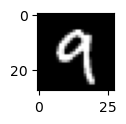

<class 'torch.Tensor'>
torch.Size([12, 28, 28])
<class 'torch.Tensor'>
torch.Size([12, 28, 28])


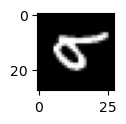

<class 'torch.Tensor'>
torch.Size([12, 3, 28, 28])


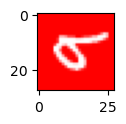

In [387]:
# for i in range(1000):
#     if train_labels[i].item() == 24:
#         plot_detail(train_images[i])
#         break

plot_detail(train_images[110])


temp = train_images[110:122]
type_it(temp)
temp2 = rotate_dataset(temp,90.5)
type_it(temp2)
plot_detail(temp2[0])
temp3 = color_dataset(temp2, 'red')
type_it(temp3)
plot_detail_color(temp3[0])



In [242]:
split10 = split_basic(train_images, train_labels)
split15 = split_basic(train_images, train_labels, 15)


<class 'torch.Tensor'>
torch.Size([6000, 28, 28])
<class 'torch.Tensor'>
torch.Size([6000])


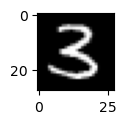

3


In [308]:
type_it(split10[2]['features'])
type_it(split10[2]['labels'])

plot_detail(split10[8]['features'][43])
print(split10[8]['labels'][43].item())

In [231]:
def visualize_label_counts(client_data: list):
    """
    Visualizes the count of labels in each client's dataset.
    
    Args:
        client_data (list): A list of dictionaries where each dictionary contains the features and labels for each client.
    """
    num_clients = len(client_data)
    
    # Create a figure with subplots
    fig, axes = plt.subplots(num_clients, 1, figsize=(5, num_clients), constrained_layout=True)
    
    if num_clients == 1:
        axes = [axes]
    
    for i, client in enumerate(client_data):
        labels = client['labels']
        
        # Count the occurrences of each label
        label_counts = torch.bincount(labels).numpy()
        
        # Generate a bar plot for the label counts
        axes[i].bar(range(len(label_counts)), label_counts)
        axes[i].set_title(f'Client {i + 1} Label Distribution')
        axes[i].set_xlabel('Label')
        axes[i].set_ylabel('Count')
        axes[i].set_xticks(range(len(label_counts)))
    
    plt.show()

60000
torch.Size([8848, 28, 28])
torch.Size([7278, 28, 28])
torch.Size([4650, 28, 28])
torch.Size([5028, 28, 28])
torch.Size([9259, 28, 28])
torch.Size([6206, 28, 28])
torch.Size([3359, 28, 28])
torch.Size([4228, 28, 28])
torch.Size([5646, 28, 28])
torch.Size([5498, 28, 28])


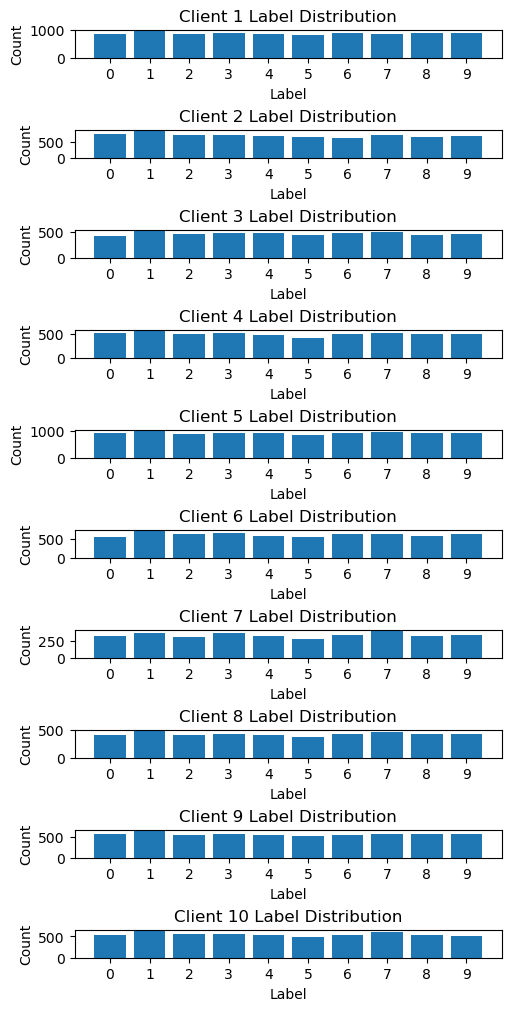

In [334]:

# Split dataset into 10 clients
client_data = split_unbalanced(train_images, train_labels, client_number=10, std_dev=2)
print(sum([len(client['features']) for client in client_data]))
for i in range(10):
    print(client_data[i]['features'].size())
# Visualize the label counts for each client
visualize_label_counts(client_data)

In [416]:
def assigning_rotation_features(
    datapoint_number: int,
    rotations: int = 4,
    scaling: float = 0.1,
    random_order: bool = True
) -> list:
    '''
    Assigns a rotation to each datapoint based on a softmax distribution.

    Args:
        datapoint_number (int): The number of datapoints to assign rotations to.
        rotations (int): The number of possible rotations. Recommended to be [2,4].
        scaling (float): The scaling factor for the softmax distribution.
        random_order (bool): Whether to shuffle the order of the rotations.
    '''
    assert 0 <= scaling <= 1, "k must be between 0 and 1."
    assert rotations > 1, "Must have at least 2 rotations."

    # Scale the values based on k
    values = np.arange(rotations, 0, -1)  # From N to 1
    scaled_values = values * scaling
    
    # Apply softmax to get the probabilities
    exp_values = np.exp(scaled_values)
    probabilities = exp_values / np.sum(exp_values)

    angles = [i * 360 / rotations for i in range(rotations)]
    if random_order:
        np.random.shuffle(angles)

    angles_assigned = np.random.choice(angles, size=datapoint_number, p=probabilities)

    return angles_assigned

In [423]:
temp_dp = assigning_rotation_features(100, rotations = 4, scaling = 1)
print(temp_dp)
count = 0
for i in range(100):
    if temp_dp[i] == 270:
        count += 1
print(count)

[180. 180. 180. 180. 180. 180. 180. 270. 180. 180. 180. 270. 180. 180.
 270.   0. 180. 180. 270. 180. 180. 180. 270. 180. 180. 180. 270. 180.
  90. 270. 180. 180. 270. 270. 270. 180.  90. 180. 270. 180.   0. 180.
 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 180. 270. 180.
 180. 180. 180. 270.   0. 180. 270. 270. 180. 180. 180. 180. 270. 180.
 270. 180. 270. 270. 180. 180. 180.   0. 180. 270. 180. 180. 180. 180.
 180.   0. 180. 270. 180. 270.   0. 180. 180. 180. 270. 180. 180. 180.
 270. 180.]
24


In [415]:
def assigning_color_features(
    datapoint_number: int,
    colors: int = 3,
    scaling: float = 0.1,
    random_order: bool = True
) -> list:
    '''
    Assigns colors to the datapoints based on the softmax probabilities.

    Args:
        datapoint_number (int): Number of datapoints to assign colors to.
        colors (int): Number of colors to assign. Must be 2 or 3.
        scaling (float): Scaling factor for the softmax probabilities.
    '''

    assert 0 <= scaling <= 1, "k must be between 0 and 1."
    assert colors == 2 or colors == 3, "Color must be 2 or 3."
    
    # Scale the values based on k
    values = np.arange(colors, 0, -1)  # From N to 1
    scaled_values = values * scaling
    
    # Apply softmax to get the probabilities
    exp_values = np.exp(scaled_values)
    probabilities = exp_values / np.sum(exp_values)

    if colors == 2:
        letters = ['red', 'blue']
    else:
        letters = ['red', 'blue', 'green']

    if random_order:
        np.random.shuffle(letters)

    colors_assigned = np.random.choice(letters, size=datapoint_number, p=probabilities)

    return colors_assigned

In [403]:
temp_dp = assigning_color_features(100, colors = 3, scaling = 1)
print(temp_dp)
count = 0
for i in range(100):
    if temp_dp[i] == 'red':
        count += 1
print(count)

['red' 'red' 'red' 'red' 'blue' 'red' 'blue' 'red' 'red' 'red' 'red' 'red'
 'red' 'red' 'green' 'red' 'blue' 'red' 'red' 'red' 'green' 'blue' 'red'
 'red' 'blue' 'red' 'red' 'green' 'blue' 'red' 'green' 'red' 'red' 'red'
 'red' 'red' 'red' 'blue' 'blue' 'green' 'blue' 'red' 'red' 'red' 'red'
 'blue' 'red' 'red' 'red' 'blue' 'red' 'blue' 'blue' 'red' 'blue' 'blue'
 'blue' 'red' 'blue' 'red' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red'
 'red' 'red' 'red' 'red' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red'
 'green' 'red' 'green' 'red' 'green' 'green' 'blue' 'red' 'green' 'red'
 'red' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue' 'green' 'red' 'red'
 'blue']
64


In [ ]:
def split_feature_skew(
    train_features: torch.Tensor,
    train_labels: torch.Tensor,
    test_features: torch.Tensor,
    test_labels: torch.Tensor,
    client_number: int = 10,
    set_rotation: bool = False,
    rotations: int = None,
    scaling_rotation: float = 0.1,
    set_color: bool = False,
    colors: int = None,
    scaling_color: float = 0.1,
    random_order: bool = True,
) -> list:
    '''
    Splits an overall dataset into a specified number of clusters (clients) with ONLY feature skew.
    
    Args:
        train_features (torch.Tensor): The training dataset features.
        train_labels (torch.Tensor): The training dataset labels.
        test_features (torch.Tensor): The testing dataset features.
        test_labels (torch.Tensor): The testing dataset labels.
        client_number (int): The number of clients to split the data into.
        set_rotation (bool): Whether to assign rotations to the features.
        rotations (int): The number of possible rotations. Recommended to be [2,4].
        scaling_rotation (float): The scaling factor for the softmax distribution.
        set_color (bool): Whether to assign colors to the features.
        colors (int): The number of colors to assign. Must be 2 or 3.
        scaling_color (float): The scaling factor for the softmax distribution.
        random_order (bool): Whether to shuffle the order of the rotations and colors.

    Warning:
        random_order should be identical for both training and testing if not DRIFTING.

    Returns:
        list: A list of dictionaries where each dictionary contains the features and labels for each client.
                Both train and test.
    '''
    # Ensure the features and labels have the same number of samples
    assert len(train_features) == len(train_labels), "The number of samples in features and labels must be the same."
    assert len(test_features) == len(test_labels), "The number of samples in features and labels must be the same."

    # generate basic split
    basic_split_data_train = split_basic(train_features, train_labels, client_number)
    basic_split_data_test = split_basic(test_features, test_labels, client_number)

    # Process train and test splits with rotations if required
    if set_rotation:
        for client_data_train, client_data_test in zip(basic_split_data_train, basic_split_data_test):

            len_train = len(client_data_train['labels'])
            len_test = len(client_data_test['labels'])
            total_rotations = assigning_rotation_features(
                len_train + len_test, rotations, scaling_rotation, random_order
                )
            # Split the total_rotations list into train and test
            train_rotations = total_rotations[:len_train]
            test_rotations = total_rotations[len_train:]

            client_data_train['features'] = rotate_dataset(client_data_train['features'], train_rotations)
            client_data_test['features'] = rotate_dataset(client_data_test['features'], test_rotations)


    if set_color:
        for client_data_train, client_data_test in zip(basic_split_data_train, basic_split_data_test):

            len_train = len(client_data_train['labels'])
            len_test = len(client_data_test['labels'])
            total_colors = assigning_color_features(
                len_train + len_test, colors, scaling_color, random_order
                )
            # Split the total_colors list into train and test
            train_colors = total_colors[:len_train]
            test_colors = total_colors[len_train:]

            client_data_train['features'] = color_dataset(client_data_train['features'], train_colors)
            client_data_test['features'] = color_dataset(client_data_test['features'], test_colors)

    rearranged_data = []

    # Iterate through the indices of the lists
    for i in range(len(basic_split_data_train)):
        # Create a new dictionary for each client
        client_data = {
            'train_features': basic_split_data_train[i]['features'],
            'train_labels': basic_split_data_train[i]['labels'],
            'test_features': basic_split_data_test[i]['features'],
            'test_labels': basic_split_data_test[i]['labels']
        }
        # Append the new dictionary to the list
        rearranged_data.append(client_data)
            
    return rearranged_data
    


[6, 7, 8]
[9, 10]
